# Loading Data from Kaggle train set

In [37]:
#Filters out proteins that are too big to fit into ESM model

train_df = pd.read_csv ('train_practice/train.csv')
train_df['len'] = train_df['protein_sequence'].apply (lambda x: len(x))
train_df = train_df[train_df['len'] <= 2000]
train_df = train_df.reset_index()
train_df = train_df.drop(columns= ['index'])
train_df

,seq_id,protein_sequence,pH,data_source,tm,len
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451
...,...,...,...,...,...,...
30936,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8,549
30937,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2,469
30938,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6,128
30939,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7,593


# Training Data using Facebook ESM model

In [25]:
#Outputs results from ESM model into csv files that can be recompiled together.

output_loc = r'train_practice/train_esm_data'
protein_seq_list = train_df.protein_sequence

all_pdb_embed_pool_test = []

from scipy.special import softmax 

all_pdb_prob_test = []

start_loc = 0
previous_stop_loc = start_loc-1
batch_number = 1


for i,p in enumerate(protein_seq_list[start_loc:]):
    
    i_val = i + start_loc
    
    print('{} of {} complete.'.format(i+start_loc, len(protein_seq_list)))
    seq = p
            
        
    # EXTRACT EMBEDDINGS, MUTATION PROBABILITIES, ENTROPY
    data = [("protein1", seq)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
        results = t_model(batch_tokens, repr_layers=[33])
    
    logits = (results['logits'].detach().cpu().numpy()[0,].T)[4:24,1:-1]
    all_pdb_prob_test.append(softmax(logits,axis=0))
    results = results["representations"][33].detach().cpu().numpy()
    
    
    all_pdb_embed_pool_test.append (np.mean( results[0,:,:],axis=0 ))
    

    if (i_val+1) % 50 == 0 and i_val != 0:
        df = pd.DataFrame (all_pdb_embed_pool_test, columns = ['val_{}'.format(index) for index in range(1280)], index = [protein_seq_list[val] for val in range (previous_stop_loc+1, i_val+1)] )
        df = df.reset_index()
        previous_stop_loc = i_val
        batch_number +=1
        df.to_csv(output_loc+'/batch_{}.csv'.format(batch_number))
        del all_pdb_embed_pool_test, df
        all_pdb_embed_pool_test = []
        
        
    del batch_tokens, results, batch_labels, batch_strs, logits
    gc.collect(); torch.cuda.empty_cache()
    



Extracting embeddings from proteins...
0 of 30941 complete.
1 of 30941 complete.
2 of 30941 complete.
3 of 30941 complete.
4 of 30941 complete.
5 of 30941 complete.
6 of 30941 complete.
7 of 30941 complete.
8 of 30941 complete.
9 of 30941 complete.
10 of 30941 complete.
11 of 30941 complete.
12 of 30941 complete.
13 of 30941 complete.
14 of 30941 complete.
15 of 30941 complete.
16 of 30941 complete.
17 of 30941 complete.
18 of 30941 complete.
19 of 30941 complete.
20 of 30941 complete.
21 of 30941 complete.
22 of 30941 complete.
23 of 30941 complete.
24 of 30941 complete.


KeyboardInterrupt: 

# Combines and merges CSV outputs from ESM model into one dataframe with the train dataset

In [38]:
#Combines all csv files into one dataframe

import glob

path = r'train_practice/train_esm_data'

file_list = glob.glob (path+ '/*.csv')

esm_df_list = []

for file_path in file_list:
    df = pd.read_csv(file_path)
    df = df.drop(columns = 'Unnamed: 0')
    esm_df_list.append (df)
    del df
    
esm_df = pd.concat (esm_df_list, axis = 0)
esm_df = esm_df.reset_index()
esm_df = esm_df.drop(columns = 'level_0')    


In [39]:
#Merges ESM data with train dataset

train_df.drop_duplicates(inplace = True)
esm_df.drop_duplicates(inplace = True)
train_esm_df = train_df.merge (esm_df, left_on = 'protein_sequence', right_on='index', how = 'inner', copy = False)
train_esm_df 

,seq_id,protein_sequence,pH,data_source,tm,len,index,val_0,val_1,val_2,...,val_1270,val_1271,val_1272,val_1273,val_1274,val_1275,val_1276,val_1277,val_1278,val_1279
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,0.070272,-0.103626,0.000051,...,0.021490,0.010370,-0.083141,0.048202,0.042827,-0.113870,0.067741,-0.088222,-0.000578,0.045665
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,0.065263,-0.003656,-0.046355,...,-0.012303,0.009551,-0.127899,0.028661,0.071649,-0.152952,-0.026640,-0.124405,0.068477,0.131550
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,0.000199,-0.017173,0.027453,...,0.005075,-0.077039,-0.100030,0.046811,-0.017856,-0.103356,-0.003648,-0.051043,-0.009875,0.166357
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,0.040494,0.039582,-0.020207,...,0.077136,0.072287,-0.094977,0.040217,0.014895,-0.021382,-0.007393,-0.049179,-0.079018,0.026522
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,-0.031081,-0.099478,-0.077342,...,-0.051524,-0.055463,-0.139862,0.014532,-0.005926,-0.142504,0.023881,-0.212277,0.062078,0.174666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30895,31344,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,376,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,0.049357,-0.056817,-0.010825,...,0.137927,0.010298,-0.055115,-0.036291,-0.057015,-0.030272,0.102598,-0.142797,-0.046975,0.063673
30896,31345,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,438,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,0.059613,-0.070241,-0.073921,...,0.099776,-0.025562,0.029401,0.028119,-0.047959,-0.012322,0.050926,-0.154950,-0.049711,0.087042
30897,31346,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,7.0,doi.org/10.1038/s41592-020-0801-4,45.2,610,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,0.027946,-0.035353,0.045675,...,0.099186,0.011852,-0.139978,0.058256,0.032094,-0.086518,0.006550,-0.102161,0.024443,0.114226
30898,31347,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,513,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,0.035332,-0.019168,0.021228,...,-0.029937,0.045123,-0.106136,0.020261,-0.020303,-0.104110,0.060888,-0.078448,0.014884,0.083904


# Runs PCA on ESM dataset

In [40]:
from sklearn.decomposition import PCA

pca_list = [col for col in train_esm_df.columns.tolist() if col.__contains__('val')]

pca_pool = PCA(n_components=0.99)
pca_esm = pca_pool.fit_transform(train_esm_df[pca_list])

pca_esm_df = pd.DataFrame (pca_esm, columns = ['pca_val_{}'.format(i) for i in range (pca_esm.shape[1])])

final_train_df = pd.concat ([train_esm_df[[col for col in train_esm_df.columns.tolist() if col not in pca_list]], pca_esm_df], axis = 1)
final_train_df

,seq_id,protein_sequence,pH,data_source,tm,len,index,pca_val_0,pca_val_1,pca_val_2,...,pca_val_662,pca_val_663,pca_val_664,pca_val_665,pca_val_666,pca_val_667,pca_val_668,pca_val_669,pca_val_670,pca_val_671
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,-0.472965,-1.294861,0.907887,...,-0.003985,-0.014907,0.004166,0.001337,0.030509,0.002525,-0.013985,0.001890,-0.032207,-0.001543
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,-0.050209,1.163453,0.736312,...,0.033901,-0.000146,0.034726,-0.042292,-0.024884,-0.005378,-0.011401,0.012036,-0.005404,-0.002724
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,-0.564282,0.239858,0.061410,...,0.000375,-0.007376,-0.003191,-0.004818,0.010628,-0.008107,-0.004452,0.012497,0.012756,-0.014124
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,-2.083136,0.064440,0.544747,...,0.010120,0.007703,-0.015754,0.001988,0.029049,-0.017206,0.011466,-0.005577,-0.004836,0.000794
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,3.654918,2.561223,0.349237,...,0.009318,-0.026269,-0.005160,0.001748,0.013075,0.000187,0.023487,0.015622,0.009927,-0.002359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30895,31344,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,376,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,1.075105,-0.485544,0.201375,...,0.009046,0.011757,0.028947,-0.019555,0.001400,-0.035600,0.013108,0.017285,-0.049697,-0.021629
30896,31345,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,438,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,-0.246657,-0.455795,-0.311452,...,-0.002753,0.013753,0.018301,0.004200,-0.000807,-0.008450,0.009167,-0.011325,0.031390,-0.016774
30897,31346,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,7.0,doi.org/10.1038/s41592-020-0801-4,45.2,610,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,-1.122751,0.796836,0.476625,...,0.006504,0.012866,0.002004,-0.001322,0.008225,0.011759,0.003045,0.025028,0.019793,-0.026121
30898,31347,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,513,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,-0.906179,0.545786,0.635945,...,-0.010231,-0.016749,-0.032598,-0.036271,0.001471,0.003047,0.006813,0.018703,-0.009910,0.003769


In [30]:
#outputs PCA model to a pickle file for re-upload later
import pickle as pk
pk.dump (pca_pool, open ('pca.pkl','wb'))

In [16]:
#Saves pca-reduced data to an output csv file

output_loc = r'train_practice/'
final_train_df.to_csv (output_loc+'merged_train_df.csv')

# Loading train data with PCA-reduced ESM features from CSV

In [3]:
import pandas as pd
import numpy as np
import os

file_loc = r'train_practice/merged_train_df.csv'
final_train_df = pd.read_csv (file_loc)
final_train_df = final_train_df.drop(columns = 'Unnamed: 0')
final_train_df = final_train_df[final_train_df['pH'] == 7.00]
final_train_df

,seq_id,protein_sequence,pH,data_source,tm,len,index,pca_val_0,pca_val_1,pca_val_2,...,pca_val_662,pca_val_663,pca_val_664,pca_val_665,pca_val_666,pca_val_667,pca_val_668,pca_val_669,pca_val_670,pca_val_671
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7,341,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,-0.472965,-1.294861,0.907887,...,-0.003985,-0.014907,0.004166,0.001337,0.030509,0.002525,-0.013985,0.001890,-0.032207,-0.001543
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5,286,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,-0.050209,1.163453,0.736312,...,0.033901,-0.000146,0.034726,-0.042292,-0.024884,-0.005378,-0.011401,0.012036,-0.005404,-0.002724
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5,497,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,-0.564282,0.239858,0.061410,...,0.000375,-0.007376,-0.003191,-0.004818,0.010628,-0.008107,-0.004452,0.012497,0.012756,-0.014124
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2,265,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,-2.083136,0.064440,0.544747,...,0.010120,0.007703,-0.015754,0.001988,0.029049,-0.017206,0.011466,-0.005577,-0.004836,0.000794
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,1451,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,3.654918,2.561223,0.349237,...,0.009318,-0.026269,-0.005160,0.001748,0.013075,0.000187,0.023487,0.015622,0.009927,-0.002359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30895,31344,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,376,YQLMCYYTSWAKDRPIEGSFKPGNIDPCLCTHLIYAFAGMQNNEIT...,1.075105,-0.485544,0.201375,...,0.009046,0.011757,0.028947,-0.019555,0.001400,-0.035600,0.013108,0.017285,-0.049697,-0.021629
30896,31345,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5,438,YQVLHLADFHLDVQYSINGDNKHMCHDDGTERNTTLGEYGDYMCDA...,-0.246657,-0.455795,-0.311452,...,-0.002753,0.013753,0.018301,0.004200,-0.000807,-0.008450,0.009167,-0.011325,0.031390,-0.016774
30897,31346,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,7.0,doi.org/10.1038/s41592-020-0801-4,45.2,610,YRALSQPEDGSGEPEPLTAPLQPEALAPARLTAGGPRARDVAQYLL...,-1.122751,0.796836,0.476625,...,0.006504,0.012866,0.002004,-0.001322,0.008225,0.011759,0.003045,0.025028,0.019793,-0.026121
30898,31347,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2,513,YRAPLPYSDISGLNALLLRLMVPVTVVFTRDSVPLDDQEKLPFTVV...,-0.906179,0.545786,0.635945,...,-0.010231,-0.016749,-0.032598,-0.036271,0.001471,0.003047,0.006813,0.018703,-0.009910,0.003769


# Train-Test split

In [4]:
from sklearn.model_selection import train_test_split 

X = final_train_df[[col for col in final_train_df if col.__contains__('pca_val')]]
y = final_train_df.tm

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 42)

In [5]:
X_test

,pca_val_0,pca_val_1,pca_val_2,pca_val_3,pca_val_4,pca_val_5,pca_val_6,pca_val_7,pca_val_8,pca_val_9,...,pca_val_662,pca_val_663,pca_val_664,pca_val_665,pca_val_666,pca_val_667,pca_val_668,pca_val_669,pca_val_670,pca_val_671
26681,1.425661,-0.811770,-0.199003,0.060585,-0.032472,0.236596,0.593791,-0.176664,0.174391,0.277400,...,-0.013050,0.000391,0.018260,0.014732,-0.012110,0.003955,-0.004070,0.014047,-0.001188,0.000313
15981,1.928779,1.415694,1.361655,0.629628,0.309820,0.211112,-0.461293,-0.172499,-0.116625,-0.205564,...,-0.012386,-0.017110,0.024265,-0.034523,0.025422,0.007548,-0.001620,0.006628,-0.015321,-0.010702
27189,-0.469954,-1.145331,0.007904,-0.543357,-0.134059,0.047602,-0.222186,-0.741781,0.429706,-0.518380,...,0.002662,0.023202,-0.004173,-0.003894,-0.013788,0.005049,0.010998,0.002787,-0.001459,-0.004367
26246,-1.818688,-0.162246,-0.182171,-0.240456,-0.516575,-0.227856,-0.429719,0.028001,0.220393,-0.145499,...,0.037907,-0.002992,-0.018138,-0.006976,-0.017088,-0.011380,0.028437,0.007137,0.000534,-0.021850
23616,-0.994413,1.588875,0.257323,-0.473908,-0.624686,-0.334113,-0.696125,-0.355511,0.298403,0.480762,...,-0.006738,0.021716,-0.041061,-0.018955,-0.000962,0.002821,0.005162,0.004889,0.015052,0.001257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26086,0.324753,-1.158213,0.151411,0.033908,-0.118397,0.126423,0.080797,0.157402,0.371493,-0.090145,...,0.031968,0.019919,-0.006834,-0.001123,0.001111,-0.008641,-0.031980,-0.002624,-0.010622,0.008975
9445,0.137573,0.446660,1.444640,-0.173292,-0.017642,0.097809,-0.438772,-0.338146,-0.120450,-0.390332,...,-0.024608,0.010766,0.006916,-0.015928,0.010099,-0.004877,-0.006832,0.021216,0.000250,0.008068
14687,-1.702214,-0.030377,-0.066202,0.019829,-0.532447,-0.166429,0.212538,-0.119860,-0.187699,0.040079,...,0.009809,-0.003653,-0.016935,0.018360,0.023330,-0.010823,0.013025,-0.014341,-0.001470,-0.008259
22681,-1.535161,0.842664,0.214160,-0.493412,-0.745205,-0.048417,-0.271080,-0.470644,0.061680,0.405301,...,-0.019192,0.003589,-0.002372,-0.011907,-0.001058,0.024784,-0.001572,-0.000465,-0.002475,-0.019180


# XGBoost Model

In [6]:
# LOAD XGB LIBRARY
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import xgboost as xgb
import gc
print('XGB Version',xgb.__version__)

# XGB MODEL PARAMETERS
xgb_parms = { 
    'min_child_weight': 5,
    'max_depth':4, 
    'learning_rate':0.1, 
    'subsample':0.6,
    'colsample_bytree':0.2, 
    'eval_metric':'rmse',
    'objective':'reg:squarederror',
    'tree_method':'gpu_hist',
    'predictor':'gpu_predictor',
    'random_state':42
}

XGB Version 1.7.1


In [7]:
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

kf = KFold(n_splits=11, random_state = 42, shuffle = True)
os.system('mkdir xgb_models_baseline_test')

for count, (t_idx, v_idx) in enumerate (kf.split (X_train)):
    
    X_tt = X_train.iloc[t_idx]
    y_tt = y_train.iloc[t_idx]
    X_valid = X_train.iloc[v_idx]
    y_valid = y_train.iloc[v_idx]
    
    print('#'*25)
    print('### Fold',count+1)
    print('### Train size',len(t_idx),'Valid size',len(v_idx))
    print('#'*25)    
    
    dtrain = xgb.DMatrix(data=X_tt, label=y_tt)
    dvalid = xgb.DMatrix(data=X_valid, label=y_valid)
    dholdout = xgb.DMatrix(data=X_test)
    
    model = xgb.train(xgb_parms, 
                dtrain=dtrain,
                evals=[(dtrain,'train'),(dvalid,'valid')],
                num_boost_round=9999,
                early_stopping_rounds=100,
                verbose_eval=100) 
    model.save_model(f'xgb_models_baseline_test/XGB_fold{count}.xgb')    
    
    oof_preds = model.predict(dvalid)
    rsme = mean_squared_error(y_valid, oof_preds, squared=False)
    print('RSME =',rsme,'\n')
    oof[v_idx] = oof_preds
    
    del dtrain, dvalid, dholdout
    del X_tt, y_tt, X_valid, y_valid
    _ = gc.collect()
    
#     p = model.predict(dholdout)
#     preds += p/11

print('#'*25)
rsme = mean_squared_error(y_train, oof, squared=False)
print('OVERALL TRAINING RSME =',rsme,'\n')


#########################
### Fold 1
### Train size 18956 Valid size 1896
#########################
[0]	train-rmse:46.27372	valid-rmse:46.34260
[100]	train-rmse:6.92241	valid-rmse:7.41821
[200]	train-rmse:6.14949	valid-rmse:7.14683
[300]	train-rmse:5.62607	valid-rmse:7.06917
[400]	train-rmse:5.21715	valid-rmse:7.04993
[500]	train-rmse:4.87040	valid-rmse:7.00308
[600]	train-rmse:4.57733	valid-rmse:6.99857
[682]	train-rmse:4.37153	valid-rmse:7.02323
RSME = 7.023508856843816 

#########################
### Fold 2
### Train size 18956 Valid size 1896
#########################
[0]	train-rmse:46.27194	valid-rmse:46.27239
[100]	train-rmse:6.88208	valid-rmse:7.75331
[200]	train-rmse:6.12076	valid-rmse:7.56362
[300]	train-rmse:5.59516	valid-rmse:7.50561
[400]	train-rmse:5.18747	valid-rmse:7.47306
[500]	train-rmse:4.85161	valid-rmse:7.45818
[600]	train-rmse:4.55266	valid-rmse:7.44960
[700]	train-rmse:4.30327	valid-rmse:7.44842
[726]	train-rmse:4.24275	valid-rmse:7.44067
RSME = 7.4394535002296385

# Calculating RSME, Correlation, and looking at odd data points

In [8]:
print('#'*25)
rsme = mean_squared_error(y_train, oof, squared=False)

print ('Range of Tm values: {} to {}'.format (y_train.min(), y_train.max()))

print('NORMALIZED OVERALL TRAINING RSME =',rsme/(y_train.max() - y_train.min()),'\n')


#########################
Range of Tm values: 0.0 to 130.0
NORMALIZED OVERALL TRAINING RSME = 0.05579681632121146 



In [9]:
from scipy.stats import spearmanr, pearsonr, rankdata

train_df_predict = pd.DataFrame (np.concatenate((y_train.values.reshape(-1,1), oof.reshape(-1,1)),axis=1), columns = ['True TM', 'Predicted TM'])

correlation = np.abs( spearmanr(train_df_predict['Predicted TM'].values, train_df_predict['True TM'].values).correlation )
print ('Spearmen Correlation: '+str(correlation))
train_df_predict

Spearmen Correlation: 0.6350345592975197


,True TM,Predicted TM
0,51.1,50.329174
1,48.6,49.886280
2,48.4,52.761917
3,50.5,49.209160
4,50.2,43.706047
...,...,...
20847,49.6,47.928265
20848,67.5,56.649750
20849,46.3,45.801079
20850,33.8,41.709713


In [10]:
dtest = xgb.DMatrix(data=X_test, label=y_test)
test_predict = model.predict (dtest)


test_df_predict = pd.DataFrame (np.concatenate(( y_test.index.values.reshape(-1,1), y_test.values.reshape(-1,1), test_predict.reshape(-1,1)),axis=1), columns = ['Index','True TM', 'Predicted TM'])
correlation = np.abs( spearmanr(test_df_predict['Predicted TM'].values, test_df_predict['True TM'].values).correlation )
rsme = mean_squared_error(y_test, test_predict, squared=False)

print ('RSME: '+str(rsme))

print ('Normalized RSME: '+str(rsme/(y_train.max() - y_train.min())))
print ('Spearmen Correlation: '+str(correlation))

test_df_predict

RSME: 7.477874622764068
Normalized RSME: 0.05752211248280052
Spearmen Correlation: 0.6276135217280342


,Index,True TM,Predicted TM
0,26681.0,39.0,47.687050
1,15981.0,59.3,48.829403
2,27189.0,45.6,47.036766
3,26246.0,44.9,47.268738
4,23616.0,50.7,53.835056
...,...,...,...
5209,26086.0,41.5,52.227940
5210,9445.0,55.9,50.411224
5211,14687.0,40.3,44.107262
5212,22681.0,49.9,49.542580


In [12]:
test_predict = model.predict (dtest)


test_df_predict = pd.DataFrame (np.concatenate(( y_test.index.values.reshape(-1,1), y_test.values.reshape(-1,1), test_predict.reshape(-1,1)),axis=1), columns = ['Index','True TM', 'Predicted TM'])
correlation = np.abs( pearsonr(test_df_predict['Predicted TM'].values, test_df_predict['True TM'].values))
rsme = mean_squared_error(y_test, test_predict, squared=False)

print ('RSME: '+str(rsme))

print ('Normalized RSME: '+str(rsme/(y_train.max() - y_train.min())))
print ('Pearson Correlation: '+str(correlation))


RSME: 7.477874622764068
Normalized RSME: 0.05752211248280052
Spearmen Correlation: [0.80860154 0.        ]


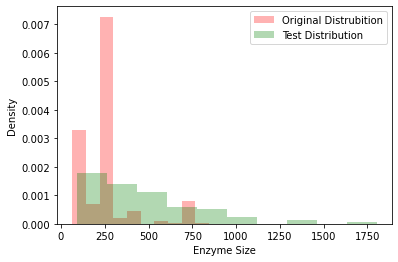

In [34]:
#final_train_df

#explore_df = final_train_df.loc [y_test.index]
test_df_predict['Index'] = test_df_predict['Index'].astype(int)
test_df_predict_format = test_df_predict.set_index('Index')

test_df_predict_merge = pd.merge (left = test_df_predict, right = final_train_df, left_index = True, right_index = True, how = 'inner')


plt.hist (final_train_df[final_train_df['tm'] < 30]['len'], alpha = 0.3, color = 'red', density = True, label= 'Original Distrubition', stacked = True)
plt.hist (test_df_predict_merge [(test_df_predict_merge['True TM'] < 30) & (test_df_predict_merge['Predicted TM'] > 30) ]['len'], alpha = 0.3, color = 'green', density = True, label = 'Test Distribution', stacked = True)
plt.ylabel ('Density')
plt.xlabel ('Enzyme Size')

plt.legend()


#test_df_predict

In [16]:
test_df_predict[(test_df_predict['True TM'] > 80) & (test_df_predict['Predicted TM'] < 25)]

,Index,True TM,Predicted TM
2802,14573,91.0,21.912971


In [18]:
final_train_df.loc[14573].len

104

# Optomizing Baseline model

In [5]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import gc

SEED = 42

xgb_search_params = { 
    'max_depth':[1,4,10], 
    'learning_rate':[0.001, 0.01, 0.1], 
    'min_child_weight':[1, 5, 10],    
    'subsample':[0.6],
    'colsample_bytree':[0.2], 
    'eval_metric':['rmse'],
    'objective':['reg:squarederror'],
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'random_state':[SEED]    
    
}


xgb_model = GridSearchCV (xgb.XGBRegressor(), param_grid = xgb_search_params, cv = 5, scoring = 'neg_mean_squared_error', )

In [6]:
xgb_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.2], 'eval_metric': ['rmse'],
                         'learning_rate': [0.001, 0.01, 0.1],
   

In [7]:
print ('Best Score: {}'.format (xgb_model.best_score_))
print ('Best Parameters: {}'.format (xgb_model.best_params_))
print ('Best Estimators: {}'.format (xgb_model.best_estimator_))

Best Score: -58.34819232440022
Best Parameters: {'colsample_bytree': 0.2, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'predictor': 'gpu_predictor', 'random_state': 42, 'subsample': 0.6, 'tree_method': 'gpu_hist'}
Best Estimators: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='gpu_predictor', random_sta